<a href="https://colab.research.google.com/github/IvanKatorgin/Deep-Learning/blob/main/Deep_Learning_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Deep Learning". Домашнее задание 4. Архитектуры свёрточных сетей. Каторгин И.П.

## Задание
Проведите эксперименты по начальному обучению различных моделей и сравните результаты.

1. Возьмите датасет EMNIST из torchvision.
2. Обучите на нём модели: ResNet 18, VGG 16, Inception v3, DenseNet 161:
- желательно обучить каждую модель с нуля по 10 эпох
- если ресурсов компьютера / Colab не хватает, достаточно обучить каждую модель по 1-2 эпохи
3. Сведите результаты обучения моделей (графики лосса) в таблицу и сравните их.

Дополнительное задание (выполняется по желанию):
- Выполните то же задание, используя датасет hymenoptera_data (https://www.kaggle.com/datasets/ajayrana/hymenoptera-data/code)

Инструкция к выполнению задания
1. Загрузите датасет, посмотрите примеры картинок в нём и проверьте наличествующие классы и их дисбаланс.
2. Создайте модель текущего типа, используя интерфейс torchvision для нужного количества классов.
3. Обучите модель с нуля до 1-10 эпох — количество эпох выбираете сами в зависимости от вычислительных ресурсов. Фиксируйте значение функции потерь в список для последующего отображения.
4. Повторите пункты 2 и 3 для всех указанных вариантов моделей.

## Загрузим библиотеки и подготовим датасет EMNIST

In [ ]:
# загрузим библиотеки
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, time, cv2
from collections import Counter
%matplotlib inline

In [ ]:
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
from torch import autograd
from torch.utils.data import DataLoader

In [ ]:
# Функция оценки точности и потерь
def evaluate_metrics(data_iter, net, loss_fn):
    loss_sum, acc_sum, n = 0, 0, 0
    net.eval()
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            loss_sum += loss_fn(y_hat, y).item()
            acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
    return loss_sum/n, acc_sum/n

In [ ]:
# Модифицированная функция обучения с сохранением всех метрик
def train(net, train_iter, test_iter, trainer, num_epochs):
    net.to(device)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    net.train()

    # Инициализация списков для метрик
    metrics = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss_fn(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
                current_loss = train_l_sum / n
                current_acc = train_acc_sum / n
                print(f"Step {i}. Train acc: {current_acc:.3f}, Loss: {current_loss:.3f}")

        # Вычисляем метрики для эпохи
        epoch_train_loss = train_l_sum / n
        epoch_train_acc = train_acc_sum / n
        epoch_test_loss, epoch_test_acc = evaluate_metrics(test_iter, net, loss_fn)

        # Сохраняем метрики
        metrics['train_loss'].append(epoch_train_loss)
        metrics['train_acc'].append(epoch_train_acc)
        metrics['test_loss'].append(epoch_test_loss)
        metrics['test_acc'].append(epoch_test_acc)

        print('-' * 50)
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.3f}')
        print(f'Test Loss:  {epoch_test_loss:.4f} | Test Acc:  {epoch_test_acc:.3f}')
        print(f'Time: {time.time()-start:.1f} sec')
        print('-' * 50)

    return metrics

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
BATCH_SIZE = 256

transoforms = tv.transforms.Compose([
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', train=True, transform=transoforms, download=True, split='mnist')
test_dataset = tv.datasets.EMNIST('.', train=False, transform=transoforms, download=True, split='mnist')
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 562M/562M [00:02<00:00, 231MB/s]


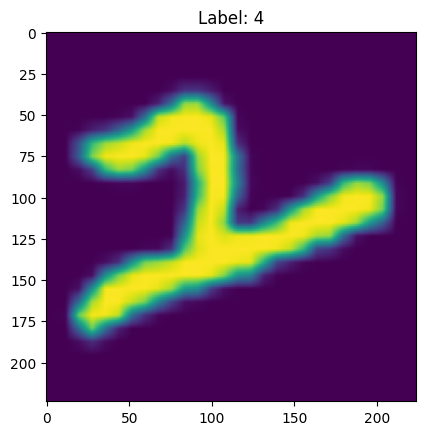

In [ ]:
# Визуализация примера
plt.imshow(train_dataset[0][0].permute(1, 2, 0).numpy())
plt.title(f"Label: {train_dataset.classes[train_dataset[0][1]]}")
plt.show()

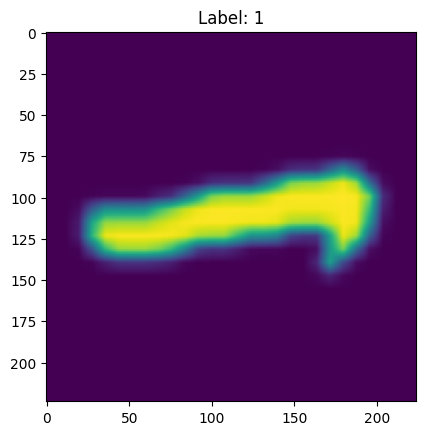

In [ ]:
# Визуализация примера
plt.imshow(test_dataset[0][0].permute(1, 2, 0).numpy())
plt.title(f"Label: {test_dataset.classes[test_dataset[0][1]]}")
plt.show()

In [ ]:
# посмотрим на количество классов
len(train_dataset.classes)

10

In [ ]:
len(test_dataset.classes)

10

In [ ]:
# посмотрим на названия классов
train_dataset.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
test_dataset.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
# посчитаем количество элементов в каждом классе (train_dataset)
values, counts = torch.unique(train_dataset.targets, return_counts=True)
print("Количество элементов в классе (train_dataset):")
for value, count in zip(values, counts):
    print(f"Class {value}: {count} samples")

Количество элементов в классе (train_dataset):
Class 0: 6000 samples
Class 1: 6000 samples
Class 2: 6000 samples
Class 3: 6000 samples
Class 4: 6000 samples
Class 5: 6000 samples
Class 6: 6000 samples
Class 7: 6000 samples
Class 8: 6000 samples
Class 9: 6000 samples


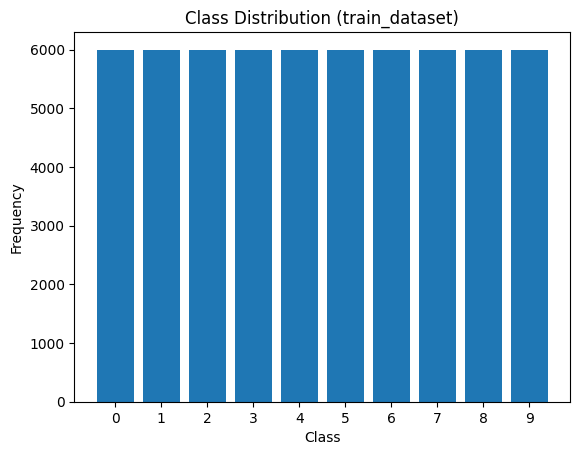

In [ ]:
# визуализируем распределение классов (train_dataset)
classes = train_dataset.classes
counts = torch.unique(train_dataset.targets, return_counts=True)[1]
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution (train_dataset)')
plt.xticks(classes)
plt.show()

In [ ]:
# посчитаем количество элементов в каждом классе (test_dataset)
values, counts = torch.unique(test_dataset.targets, return_counts=True)
print("Количество элементов в классе (test_dataset):")
for value, count in zip(values, counts):
    print(f"Class {value}: {count} samples")

Количество элементов в классе (test_dataset):
Class 0: 1000 samples
Class 1: 1000 samples
Class 2: 1000 samples
Class 3: 1000 samples
Class 4: 1000 samples
Class 5: 1000 samples
Class 6: 1000 samples
Class 7: 1000 samples
Class 8: 1000 samples
Class 9: 1000 samples


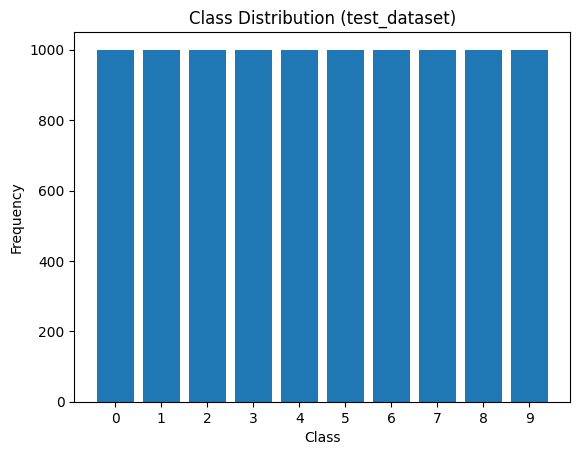

In [ ]:
# визуализируем распределение классов (test_dataset)
classes = test_dataset.classes
counts = torch.unique(test_dataset.targets, return_counts=True)[1]
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution (test_dataset)')
plt.xticks(classes)
plt.show()

Все классы сбалансированы

## ResNet 18

In [ ]:
# создадим преобразование
transforms = tv.transforms.Compose([
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor(),
    tv.transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Преобразование серого в RGB
])

# Перезагрузим наборы данных с новыми преобразованием
train_dataset = tv.datasets.EMNIST('.', train=True, transform=transforms, download=True, split='mnist')
test_dataset = tv.datasets.EMNIST('.', train=False, transform=transforms, download=True, split='mnist')

# Создадим новые DataLoaders с обновленным набором данных
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
# загрузим модель ResNet 18
model = tv.models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
model.fc = nn.Linear(512, len(train_dataset.classes))

In [ ]:
summary(model.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
trainer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
# из-за переполнения памяти сделаем 4 эпохи
metrics_resnet18 = train(model, train_iter, test_iter, trainer, 4)

Step 0. Train acc: 0.980, Loss: 0.099
Step 10. Train acc: 0.964, Loss: 0.139
Step 20. Train acc: 0.963, Loss: 0.141
Step 30. Train acc: 0.960, Loss: 0.144
Step 40. Train acc: 0.960, Loss: 0.142
Step 50. Train acc: 0.962, Loss: 0.137
Step 60. Train acc: 0.964, Loss: 0.135
Step 70. Train acc: 0.965, Loss: 0.132
Step 80. Train acc: 0.964, Loss: 0.131
Step 90. Train acc: 0.964, Loss: 0.132
Step 100. Train acc: 0.964, Loss: 0.132
Step 110. Train acc: 0.965, Loss: 0.132
Step 120. Train acc: 0.965, Loss: 0.131
Step 130. Train acc: 0.965, Loss: 0.131
Step 140. Train acc: 0.965, Loss: 0.131
Step 150. Train acc: 0.965, Loss: 0.130
Step 160. Train acc: 0.966, Loss: 0.129
Step 170. Train acc: 0.966, Loss: 0.129
Step 180. Train acc: 0.965, Loss: 0.129
Step 190. Train acc: 0.966, Loss: 0.128
Step 200. Train acc: 0.966, Loss: 0.128
Step 210. Train acc: 0.966, Loss: 0.127
Step 220. Train acc: 0.966, Loss: 0.127
Step 230. Train acc: 0.966, Loss: 0.127
--------------------------------------------------


In [ ]:
# Визуализация метрик
def plot_metrics(metrics):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

    # График потерь
    ax1.plot(metrics['train_loss'], label='Train')
    ax1.plot(metrics['test_loss'], label='Test')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # График точности
    ax2.plot(metrics['train_acc'], label='Train')
    ax2.plot(metrics['test_acc'], label='Test')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

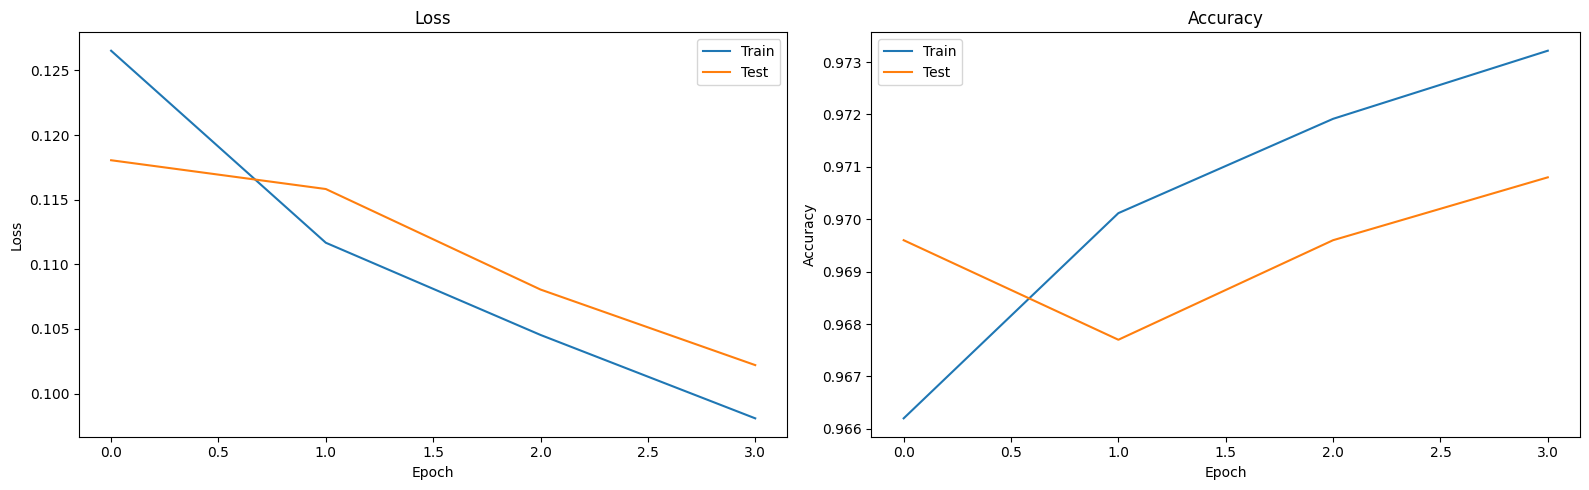

In [ ]:
# Визуализация метрик
plot_metrics(metrics_resnet18)

In [ ]:
# Сохранение метрик в таблицу
metrics_df_resnet18 = pd.DataFrame({
    'Epoch': range(1, len(metrics_resnet18['train_loss'])+1),
    'Train Loss': metrics_resnet18['train_loss'],
    'Train Acc': metrics_resnet18['train_acc'],
    'Test Loss': metrics_resnet18['test_loss'],
    'Test Acc': metrics_resnet18['test_acc']
})


In [ ]:
# Красивое отображение таблицы
def display_metrics_table(df):
    from IPython.display import display
    styled_df = df.style\
        .format({
            'Train Loss': '{:.4f}',
            'Test Loss': '{:.4f}',
            'Train Acc': '{:.2%}',
            'Test Acc': '{:.2%}'
        })\
        .background_gradient(cmap='YlGnBu', subset=['Train Acc', 'Test Acc'])\
        .background_gradient(cmap='YlOrRd', subset=['Train Loss', 'Test Loss'])
    display(styled_df)

In [ ]:
# Красивое отображение таблицы
display_metrics_table(metrics_df_resnet18)

,Epoch,Train Loss,Train Acc,Test Loss,Test Acc
0,1,0.1265,96.62%,0.1181,96.96%
1,2,0.1117,97.01%,0.1158,96.77%
2,3,0.1045,97.19%,0.1080,96.96%
3,4,0.0981,97.32%,0.1022,97.08%


In [ ]:
# Сохранение результатов
torch.save(model.state_dict(), 'emnist_resnet18.pth')
metrics_df_resnet18.to_csv('training_metrics_resnet18.csv', index=False)
print("Модель и метрики сохранены!")

Модель и метрики сохранены!


## VGG 16

In [ ]:
# создадим преобразование
transforms = tv.transforms.Compose([
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor(),
    tv.transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Преобразование серого в RGB
])

# Перезагрузим наборы данных с новыми преобразованием
train_dataset = tv.datasets.EMNIST('.', train=True, transform=transforms, download=True, split='mnist')
test_dataset = tv.datasets.EMNIST('.', train=False, transform=transforms, download=True, split='mnist')

# Создадим новые DataLoaders с обновленным набором данных
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
# загрузим модель VGG 16
model = tv.models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 123MB/s]


In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
# Меняем классификатор (должен поддерживать корректные размеры входных данных):
model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, len(train_dataset.classes)))  # 10 классов MNIST

In [ ]:
summary(model.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [ ]:
trainer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
# из-за переполнения памяти сделаем 4 эпохи
metrics_vgg16 = train(model, train_iter, test_iter, trainer, 4)

Step 0. Train acc: 0.109, Loss: 2.304
Step 10. Train acc: 0.542, Loss: 2.797
Step 20. Train acc: 0.740, Loss: 1.543
Step 30. Train acc: 0.814, Loss: 1.082
Step 40. Train acc: 0.853, Loss: 0.838
Step 50. Train acc: 0.878, Loss: 0.689
Step 60. Train acc: 0.895, Loss: 0.585
Step 70. Train acc: 0.907, Loss: 0.512
Step 80. Train acc: 0.916, Loss: 0.457
Step 90. Train acc: 0.924, Loss: 0.412
Step 100. Train acc: 0.929, Loss: 0.377
Step 110. Train acc: 0.934, Loss: 0.349
Step 120. Train acc: 0.938, Loss: 0.326
Step 130. Train acc: 0.941, Loss: 0.307
Step 140. Train acc: 0.943, Loss: 0.290
Step 150. Train acc: 0.946, Loss: 0.275
Step 160. Train acc: 0.948, Loss: 0.263
Step 170. Train acc: 0.950, Loss: 0.252
Step 180. Train acc: 0.952, Loss: 0.240
Step 190. Train acc: 0.954, Loss: 0.231
Step 200. Train acc: 0.955, Loss: 0.222
Step 210. Train acc: 0.957, Loss: 0.215
Step 220. Train acc: 0.958, Loss: 0.208
Step 230. Train acc: 0.959, Loss: 0.201
--------------------------------------------------


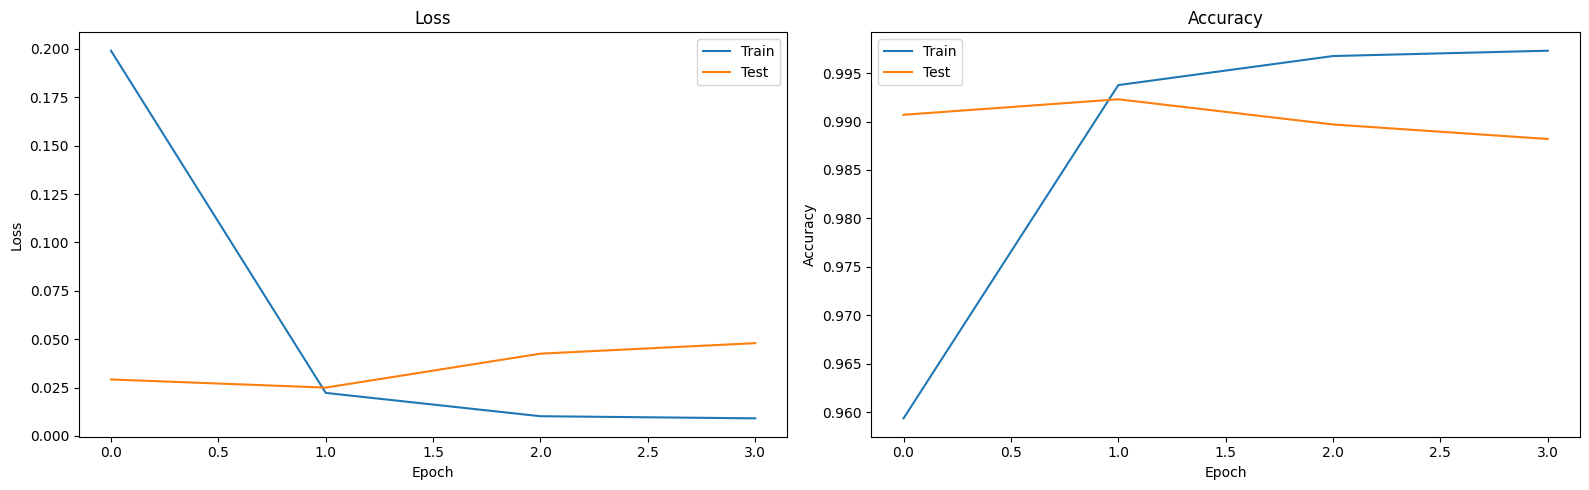

In [ ]:
# Визуализация метрик
plot_metrics(metrics_vgg16)

In [ ]:
# Сохранение метрик в таблицу
metrics_df_vgg16 = pd.DataFrame({
    'Epoch': range(1, len(metrics_vgg16['train_loss'])+1),
    'Train Loss': metrics_vgg16['train_loss'],
    'Train Acc': metrics_vgg16['train_acc'],
    'Test Loss': metrics_vgg16['test_loss'],
    'Test Acc': metrics_vgg16['test_acc']
})

In [ ]:
# Красивое отображение таблицы
display_metrics_table(metrics_df_vgg16)

,Epoch,Train Loss,Train Acc,Test Loss,Test Acc
0,1,0.1991,95.94%,0.0292,99.07%
1,2,0.0222,99.38%,0.0250,99.23%
2,3,0.0102,99.68%,0.0425,98.97%
3,4,0.0091,99.73%,0.0479,98.82%


In [ ]:
# Сохранение результатов
torch.save(model.state_dict(), 'emnist_vgg16.pth')
metrics_df_vgg16.to_csv('training_metrics_vgg16.csv', index=False)
print("Модель и метрики сохранены!")

Модель и метрики сохранены!


## Inception v3

In [ ]:
# Модифицированная функция обучения для Inception_v3
def train_inception(net, train_iter, test_iter, trainer, num_epochs):
    net.to(device)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    net.train()

    # Убедимся, что aux_logits отключены
    if isinstance(net, tv.models.Inception3):
        net.aux_logits = False

    metrics = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        start = time.time()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()

            # Прямой проход
            outputs = net(X)

            # Для Inception_v3 с aux_logits=False получаем только основной выход
            l = loss_fn(outputs, y)
            l.backward()
            trainer.step()

            train_l_sum += l.item()
            train_acc_sum += (outputs.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 20 == 0:
                print(f"Batch {i}: Loss={train_l_sum/n:.3f}, Acc={train_acc_sum/n:.3f}")

        # Вычисление метрик после эпохи
        epoch_train_loss = train_l_sum / n
        epoch_train_acc = train_acc_sum / n

        # Функция оценки
        def evaluate_model(data_iter, net):
            net.eval()
            loss_sum, acc_sum, n = 0, 0, 0
            with torch.no_grad():
                for X, y in data_iter:
                    X, y = X.to(device), y.to(device)
                    outputs = net(X)
                    loss_sum += loss_fn(outputs, y).item()
                    acc_sum += (outputs.argmax(1) == y).sum().item()
                    n += y.shape[0]
            return loss_sum/n, acc_sum/n

        epoch_test_loss, epoch_test_acc = evaluate_model(test_iter, net)

        # Сохранение метрик
        metrics['train_loss'].append(epoch_train_loss)
        metrics['train_acc'].append(epoch_train_acc)
        metrics['test_loss'].append(epoch_test_loss)
        metrics['test_acc'].append(epoch_test_acc)

        print(f"\nEpoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {epoch_train_loss:.4f} | Acc: {epoch_train_acc:.3f}")
        print(f"Test Loss:  {epoch_test_loss:.4f} | Acc:  {epoch_test_acc:.3f}")
        print(f"Time: {time.time()-start:.1f}s\n")

    return metrics

In [ ]:
# Создадим преобразование с правильным размером для Inception_v3 (299x299)
transforms = tv.transforms.Compose([
    tv.transforms.Resize((299, 299)),  # Inception_v3 требует 299x299
    tv.transforms.ToTensor(),
    tv.transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Преобразование серого в RGB
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация для pretrained
])

# Перезагрузим наборы данных с новыми преобразованием
train_dataset = tv.datasets.EMNIST('.', train=True, transform=transforms, download=True, split='mnist')
test_dataset = tv.datasets.EMNIST('.', train=False, transform=transforms, download=True, split='mnist')

# Создадим новые DataLoaders с обновленным набором данных
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
# загрузим модель inception_v3
model = tv.models.inception_v3(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
# Меняем последний слой
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))

In [ ]:
summary(model.to(device), input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [ ]:
print("Trainable Parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")

Trainable Parameters:
fc.weight: torch.Size([10, 2048])
fc.bias: torch.Size([10])


In [ ]:
trainer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# из-за переполнения памяти сделаем 4 эпохи
metrics_inception_v3 = train_inception(model, train_iter, test_iter, trainer, 4)

Batch 0: Loss=2.359, Acc=0.074
Batch 20: Loss=1.943, Acc=0.397
Batch 40: Loss=1.641, Acc=0.544
Batch 60: Loss=1.453, Acc=0.609
Batch 80: Loss=1.315, Acc=0.650
Batch 100: Loss=1.217, Acc=0.678
Batch 120: Loss=1.137, Acc=0.701
Batch 140: Loss=1.077, Acc=0.715
Batch 160: Loss=1.027, Acc=0.727
Batch 180: Loss=0.983, Acc=0.738
Batch 200: Loss=0.945, Acc=0.747
Batch 220: Loss=0.914, Acc=0.755

Epoch 1/4:
Train Loss: 0.8952 | Acc: 0.759
Test Loss:  0.4866 | Acc:  0.879
Time: 427.2s

Batch 0: Loss=0.457, Acc=0.887
Batch 20: Loss=0.470, Acc=0.885
Batch 40: Loss=0.460, Acc=0.885
Batch 60: Loss=0.454, Acc=0.888
Batch 80: Loss=0.451, Acc=0.888
Batch 100: Loss=0.442, Acc=0.890
Batch 120: Loss=0.435, Acc=0.892
Batch 140: Loss=0.429, Acc=0.892
Batch 160: Loss=0.423, Acc=0.893
Batch 180: Loss=0.419, Acc=0.894
Batch 200: Loss=0.414, Acc=0.895
Batch 220: Loss=0.408, Acc=0.896

Epoch 2/4:
Train Loss: 0.4047 | Acc: 0.897
Test Loss:  0.3514 | Acc:  0.906
Time: 401.7s

Batch 0: Loss=0.351, Acc=0.895
Batch 2

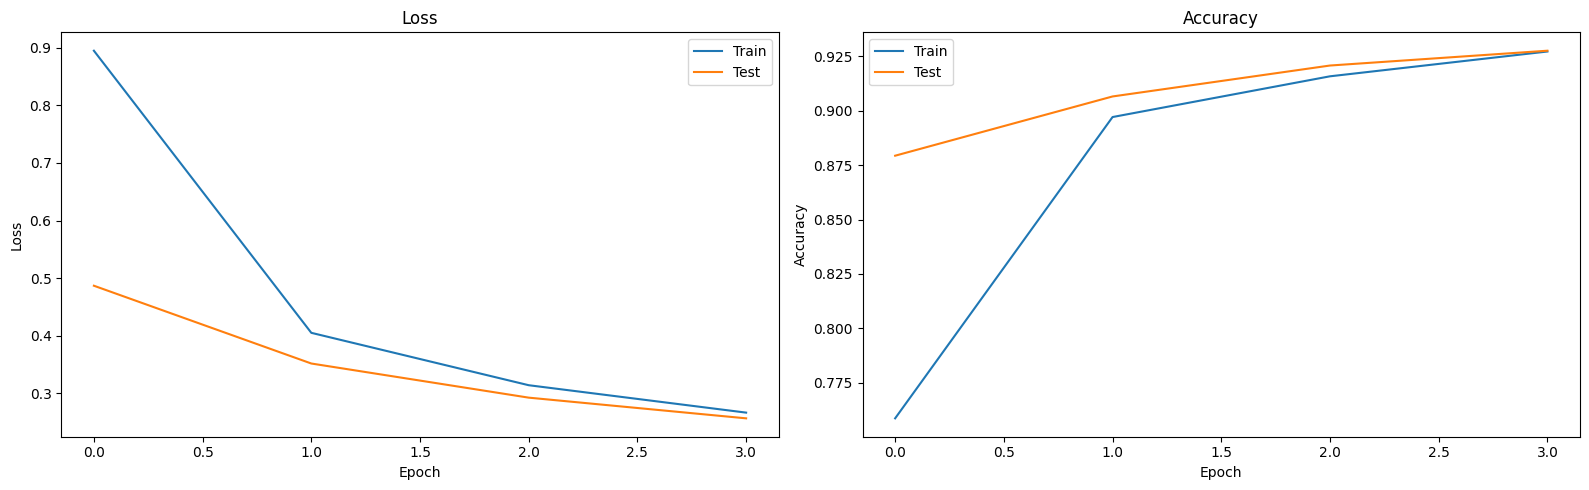

In [ ]:
# Визуализация метрик
plot_metrics(metrics_inception_v3)

In [ ]:
# Сохранение метрик в таблицу
metrics_df_inception_v3 = pd.DataFrame({
    'Epoch': range(1, len(metrics_inception_v3['train_loss'])+1),
    'Train Loss': metrics_inception_v3['train_loss'],
    'Train Acc': metrics_inception_v3['train_acc'],
    'Test Loss': metrics_inception_v3['test_loss'],
    'Test Acc': metrics_inception_v3['test_acc']
})

In [ ]:
# Красивое отображение таблицы
display_metrics_table(metrics_df_inception_v3)

,Epoch,Train Loss,Train Acc,Test Loss,Test Acc
0,1,0.8952,75.87%,0.4866,87.93%
1,2,0.4047,89.70%,0.3514,90.65%
2,3,0.3136,91.57%,0.2920,92.07%
3,4,0.2659,92.71%,0.2560,92.75%


In [ ]:
# Сохранение результатов
torch.save(model.state_dict(), 'emnist_inception_v3.pth')
metrics_df_inception_v3.to_csv('training_metrics_inception_v3.csv', index=False)
print("Модель и метрики сохранены!")

Модель и метрики сохранены!


## DenseNet 161

In [ ]:
BATCH_SIZE = 64
input_size = (3, 224, 224)

# Преобразования
transforms = tv.transforms.Compose([
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor(),
    tv.transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Загрузка данных
train_dataset = tv.datasets.EMNIST('.', train=True, transform=transforms, download=True, split='mnist')
test_dataset = tv.datasets.EMNIST('.', train=False, transform=transforms, download=True, split='mnist')
train_iter = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
# загрузим модель DenseNet 161
model = tv.models.densenet161(pretrained=True)

In [ ]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.classifier.in_features

2208

In [ ]:
# Меняем классификатор
model.classifier = nn.Linear(2208, len(train_dataset.classes))

In [ ]:
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

In [ ]:
# Вывод информации
print("\nDenseNet161 Configuration:")
print(f"Input size: {input_size}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classifier input features: {model.classifier.in_features}")
print(f"Classifier output features: {model.classifier.out_features}")


DenseNet161 Configuration:
Input size: (3, 224, 224)
Number of classes: 10
Classifier input features: 2208
Classifier output features: 10


In [ ]:
# Проверка обучаемых параметров
print("\nTrainable Parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")


Trainable Parameters:
classifier.weight: torch.Size([10, 2208])
classifier.bias: torch.Size([10])


In [ ]:
# Проверка прямого прохода
test_input = torch.randn(1, *input_size).to(device)
try:
    output = model(test_input)
    print(f"\nTest forward pass successful! Output shape: {output.shape}")
except Exception as e:
    print(f"\nForward pass error: {e}")


Forward pass error: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same


In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.weight
	 classifier.bias


In [ ]:
trainer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
# из-за переполнения памяти сделаем 4 эпохи
metrics_denseNet161 = train(model, train_iter, test_iter, trainer, 4)

Step 0. Train acc: 0.109, Loss: 2.303
Step 10. Train acc: 0.301, Loss: 2.054
Step 20. Train acc: 0.479, Loss: 1.804
Step 30. Train acc: 0.565, Loss: 1.627
Step 40. Train acc: 0.627, Loss: 1.478
Step 50. Train acc: 0.660, Loss: 1.369
Step 60. Train acc: 0.696, Loss: 1.267
Step 70. Train acc: 0.722, Loss: 1.184
Step 80. Train acc: 0.742, Loss: 1.119
Step 90. Train acc: 0.760, Loss: 1.060
Step 100. Train acc: 0.775, Loss: 1.008
Step 110. Train acc: 0.787, Loss: 0.962
Step 120. Train acc: 0.796, Loss: 0.924
Step 130. Train acc: 0.806, Loss: 0.887
Step 140. Train acc: 0.812, Loss: 0.858
Step 150. Train acc: 0.822, Loss: 0.825
Step 160. Train acc: 0.828, Loss: 0.797
Step 170. Train acc: 0.835, Loss: 0.770
Step 180. Train acc: 0.840, Loss: 0.748
Step 190. Train acc: 0.845, Loss: 0.726
Step 200. Train acc: 0.850, Loss: 0.706
Step 210. Train acc: 0.854, Loss: 0.686
Step 220. Train acc: 0.858, Loss: 0.669
Step 230. Train acc: 0.861, Loss: 0.654
Step 240. Train acc: 0.864, Loss: 0.640
Step 250. T

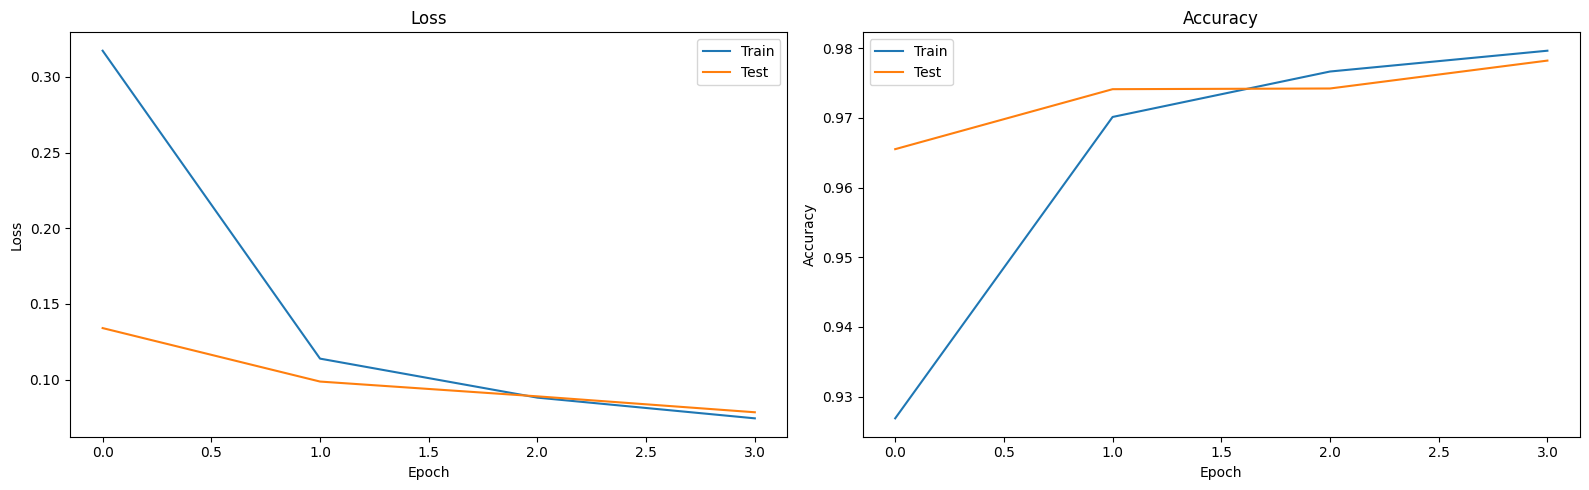

In [ ]:
# Визуализация метрик
plot_metrics(metrics_denseNet161)

In [ ]:
# Сохранение метрик в таблицу
metrics_df_denseNet161 = pd.DataFrame({
    'Epoch': range(1, len(metrics_denseNet161['train_loss'])+1),
    'Train Loss': metrics_denseNet161['train_loss'],
    'Train Acc': metrics_denseNet161['train_acc'],
    'Test Loss': metrics_denseNet161['test_loss'],
    'Test Acc': metrics_denseNet161['test_acc']
})

In [ ]:
# Красивое отображение таблицы
display_metrics_table(metrics_df_denseNet161)

,Epoch,Train Loss,Train Acc,Test Loss,Test Acc
0,1,0.3173,92.69%,0.1341,96.55%
1,2,0.1139,97.01%,0.0988,97.41%
2,3,0.0881,97.66%,0.0890,97.42%
3,4,0.0745,97.96%,0.0785,97.82%


In [ ]:
# Сохранение результатов
torch.save(model.state_dict(), 'emnist_denseNet161.pth')
metrics_df_denseNet161.to_csv('training_metrics_denseNet161.csv', index=False)
print("Модель и метрики сохранены!")

Модель и метрики сохранены!


## Сводная таблица и график

In [ ]:
# Создаем сводную таблицу всех метрик
def create_metrics_table(*all_metrics):
    """Объединяет метрики из всех экспериментов в одну таблицу"""
    dfs = []

    for i, metrics in enumerate(all_metrics, 1):
        df = pd.DataFrame({
            'Epoch': range(1, len(metrics['train_loss'])+1),
            'Model': f'Model_{i}',
            'Train_Loss': metrics['train_loss'],
            'Train_Acc': metrics['train_acc'],
            'Test_Loss': metrics['test_loss'],
            'Test_Acc': metrics['test_acc']
        })
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

In [ ]:
# Функция для визуализации всех метрик
def plot_combined_metrics(combined_df):
    plt.figure(figsize=(16, 10))

    # Уникальные модели
    models = combined_df['Model'].unique()
    n_models = len(models)

    # Цветовая схема
    colors = plt.cm.tab10(np.linspace(0, 1, n_models))

    # График потерь
    plt.subplot(2, 2, 1)
    for i, model in enumerate(models):
        model_df = combined_df[combined_df['Model'] == model]
        plt.plot(model_df['Epoch'], model_df['Train_Loss'],
                label=f'{model} Train', color=colors[i], linestyle='-')
        plt.plot(model_df['Epoch'], model_df['Test_Loss'],
                label=f'{model} Test', color=colors[i], linestyle='--')
    plt.title('Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # График точности
    plt.subplot(2, 2, 2)
    for i, model in enumerate(models):
        model_df = combined_df[combined_df['Model'] == model]
        plt.plot(model_df['Epoch'], model_df['Train_Acc'],
                label=f'{model} Train', color=colors[i], linestyle='-')
        plt.plot(model_df['Epoch'], model_df['Test_Acc'],
                label=f'{model} Test', color=colors[i], linestyle='--')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Boxplot потерь
    plt.subplot(2, 2, 3)
    box_data = [combined_df[combined_df['Model'] == m]['Test_Loss'] for m in models]
    plt.boxplot(box_data, labels=models)
    plt.title('Test Loss Distribution')
    plt.ylabel('Loss')

    # Boxplot точности
    plt.subplot(2, 2, 4)
    box_data = [combined_df[combined_df['Model'] == m]['Test_Acc'] for m in models]
    plt.boxplot(box_data, labels=models)
    plt.title('Test Accuracy Distribution')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

In [ ]:
# Создаем и сохраняем сводный отчет
def create_full_report(combined_df):
    # Группировка по модели
    report = combined_df.groupby('Model').agg({
        'Train_Loss': ['min', 'mean', 'max'],
        'Train_Acc': ['max', 'mean', 'min'],
        'Test_Loss': ['min', 'mean', 'max'],
        'Test_Acc': ['max', 'mean', 'min']
    })

    # Сохранение в файлы
    combined_df.to_csv('all_models_metrics.csv', index=False)
    report.to_csv('models_summary_report.csv')

    # Красивое отображение
    styled_report = report.style\
        .format('{:.4f}', subset=[('Train_Loss', 'mean'), ('Test_Loss', 'mean')])\
        .format('{:.2%}', subset=[('Train_Acc', 'mean'), ('Test_Acc', 'mean')])\
        .background_gradient(cmap='Blues')

    return styled_report

In [ ]:
# объединим все метрики всех моделей в одну таблицу
combined_df = create_metrics_table(metrics_resnet18, metrics_vgg16, metrics_inception_v3, metrics_denseNet161)
combined_df

,Epoch,Model,Train_Loss,Train_Acc,Test_Loss,Test_Acc
0,1,Model_1,0.126527,0.966200,0.118053,0.9696
1,2,Model_1,0.111669,0.970117,0.115826,0.9677
2,3,Model_1,0.104536,0.971917,0.108048,0.9696
3,4,Model_1,0.098083,0.973217,0.102202,0.9708
4,1,Model_2,0.199081,0.959350,0.029176,0.9907
5,2,Model_2,0.022229,0.993767,0.024966,0.9923
6,3,Model_2,0.010175,0.996767,0.042511,0.9897
7,4,Model_2,0.009079,0.997317,0.047938,0.9882
8,1,Model_3,0.895215,0.758733,0.486602,0.8793
9,2,Model_3,0.404702,0.897050,0.351351,0.9065


<ipython-input-77-f01f34a9a744>:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=models)
<ipython-input-77-f01f34a9a744>:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=models)


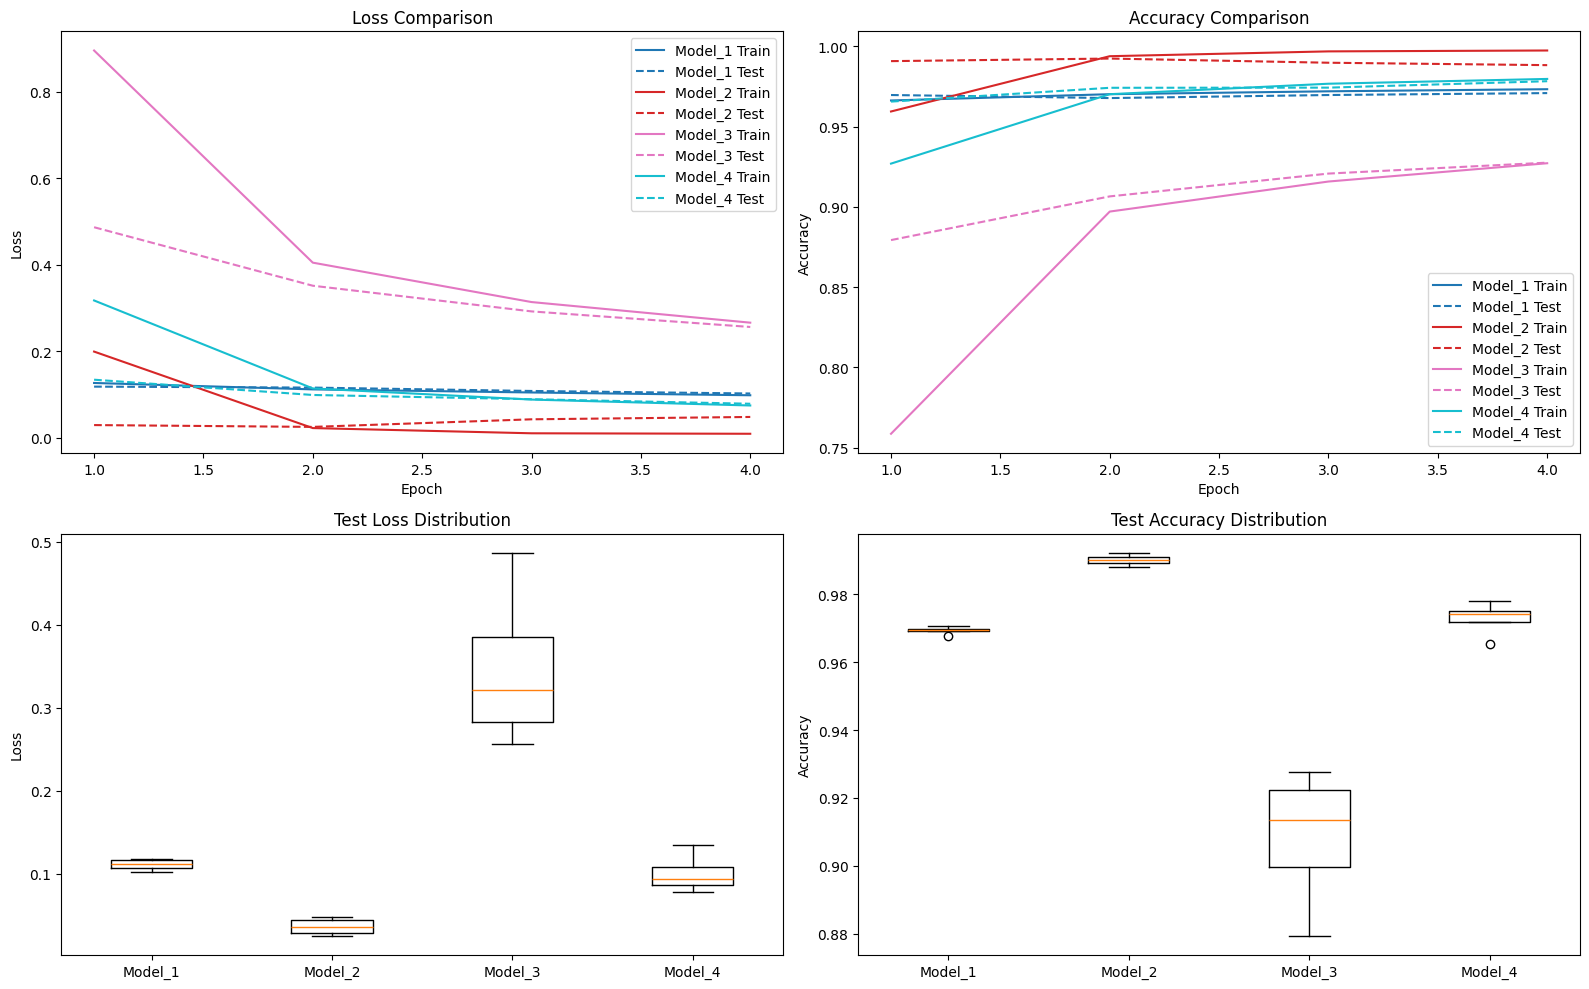

In [ ]:
# строим график
plot_combined_metrics(combined_df)

In [ ]:
# сохранаем отчет
report = create_full_report(combined_df)
display(report)

Выводы:
1. Обучены модели ResNet 18, VGG 16, Inception v3, DenseNet 161 на датасете EMNIST
2. Оценки качества всех моделей достаточно высокие, несмотря на малое количество эпох обучения
3. Все модели могут быть использованы в дальнейшем

Дополнительное задание выполнено в другом ноутбуке и приложено отдельно